In [110]:
from pathlib import Path
import re, os, sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
import roicat

import roi_tracking_helpers
importlib.reload(roi_tracking_helpers)
from roi_tracking_helpers import roicat_align_rois, roicat_visualize_tracked_rois


In [107]:
# Choose sessions and paths
sessions_to_align = ['ses-011_date-20250315_protocol-t5', 'ses-012_date-20250318_protocol-t6']
protocol_nums = [int(re.search(r'protocol-t(\d+)', s).group(1)) for s in sessions_to_align]

basepath = Path('/Volumes/mrsic_flogel/public/projects/AtApSuKuSaRe_20250129_HFScohort2')
animal = 'TAA0000066'
func_img_path = 'funcimg/Session'
tracking_path = basepath / animal / '_'.join(f't{n}' for n in protocol_nums)
savepath = tracking_path / 'analysis' 
roicat_data_name = animal 

roicat_dir = r'/Users/athinaapostolelli/Documents/SWC/VR_ABCD_project/ROICaT'

In [ ]:
# Load data to align
data_to_align = [[] for s in range(len(sessions_to_align))]
for s, sess in enumerate(sessions_to_align):
    DF_F_file = os.path.join(basepath, animal, sess, func_img_path, 'suite2p/plane0/DF_F0.npy')
    valid_frames_file = os.path.join(basepath, animal, sess, 'valid_frames.npz')

    if os.path.exists(DF_F_file) and os.path.exists(valid_frames_file):
        valid_frames = np.load(valid_frames_file)['valid_frames']

        DF_F_all = np.load(DF_F_file)
        DF_F = DF_F_all[:, valid_frames]

        data_to_align[s] = DF_F
        
    else:
        raise FileNotFoundError('Either the valid_frames.npz or the DF_F0.npy file does not exist in this directory.')


In [ ]:
# Align the data
if os.path.exists(os.path.join(tracking_path, f'roicat_aligned_ROIs_{'_'.join(f't{n}' for n in protocol_nums)}.npy')):
    print('Found ROIs alignment for these sessions. Loading...')
    idx_original_aligned = np.load(os.path.join(tracking_path, f'roicat_aligned_ROIs_{'_'.join(f't{n}' for n in protocol_nums)}.npy'))
else:
    _, idx_original_aligned = roicat_align_rois(roicat_dir=roicat_dir,
                        roicat_data_name=roicat_data_name,
                        sessions_to_align=sessions_to_align,
                        basepath=basepath,
                        animal=animal,
                        alignment_method='DF_F0',  # this is ignored if data is not None
                        data=data_to_align,
                        plot_alignment=False,
                        savepath=tracking_path)

Found ROIs alignment for these sessions. Loading...



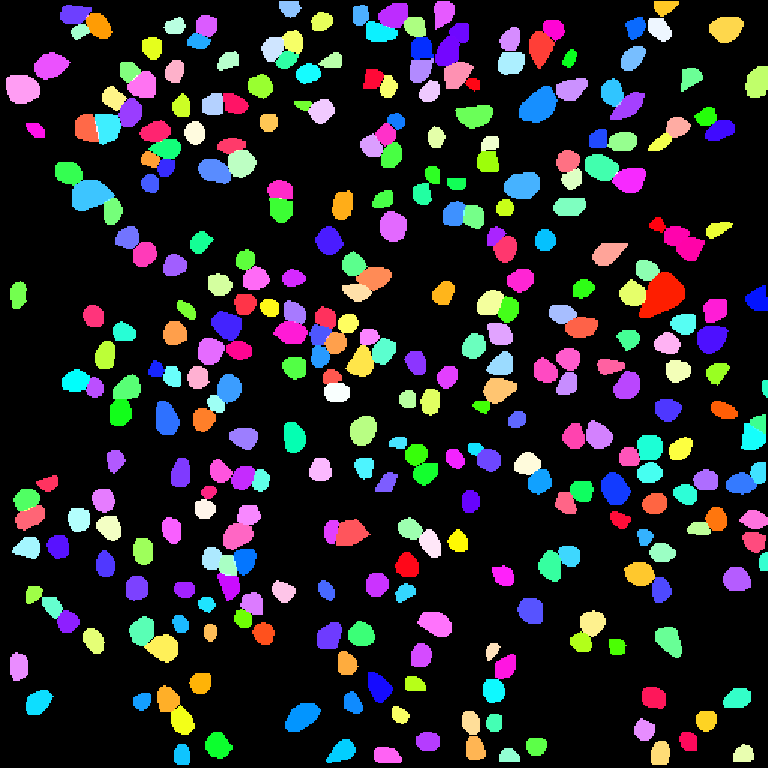

In [112]:
# Visualize ROIs

# Keep neurons that have been clustered in all sessions
idx_array = np.vstack(idx_original_aligned)  # shape: (n_sessions, n_neurons)
valid_mask = np.all(~np.isnan(idx_array), axis=0)  # Find neurons that are not nan in all sessions
valid_indices = np.where(valid_mask)[0]  # Get the indices that are valid across all sessions
tracked_neuron_ids = [session[valid_indices].astype(int) for session in idx_original_aligned]
roicat_data_name = animal 

roicat_visualize_tracked_rois(roicat_dir, roicat_data_name, sessions_to_align=sessions_to_align, tracked_neuron_ids=tracked_neuron_ids)